<a href="https://colab.research.google.com/github/idnm/classiq/blob/master/C14X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classiq Coding Competition Spring 2022
### Second Place MCX Submission by Nikita Nemkov

### DESCRIPTION

The approach (mostly standard+use of relative phase Toffoli gates) is described in detail in the attached notebook. The notebook should work out of the box in Colab. Please note that my order of qubits may be reversed compared to yours, i.e. in qiskit you may need to run qc.reverse_bits() on my circuit. Other than that, I made sure to follow the ordering conventions in the problem.

In [1]:
try:
  import qiskit
except ImportError:
  !pip install qiskit
try:
  import pylatexenc
except ImportError:
  !pip install pylatexenc
  
from qiskit import transpile, QuantumCircuit, QuantumRegister
from qiskit.circuit.library import *
from qiskit.quantum_info import OneQubitEulerDecomposer, random_clifford, Operator, Statevector
from qiskit.extensions import UnitaryGate
from qiskit.circuit import Instruction
from typing import Union
import numpy as np

# Readme

The QASM of the resulting circuit is provided in the very last cell of this notebook. Final depth is 70. Please note that I do not follow Qiskit's convention for ordering qubits, i.e. mine is 'big-endian'. Other than that I made sure to place qubits as required in the problem -- first 14 controls, then target, then 5 ancilla qubits. 

To reproduce construction of the circuit 'run all cells'. The notebook should work in Colab out of the box.


The basic idea is to first split 14 controls into four groups (4+4+3+3) and store results of each group in an ancilla qubit. Then take these four ancilla qubits and apply Toffoli 5 gate on the target qubit (using the last remaining ancilla qubit). Then uncompute. The main technical trick is to use relative phase Toffoli gates, as advocated by [Maslov](https://arxiv.org/abs/1508.03273). I also came up with a relative phase Toffoli 5 gate which I didn't find in the literature.

# Auxilary functions

Placeholder instruction thanks to [Egretta.Thula@stackexchange](https://quantumcomputing.stackexchange.com/questions/23589/is-there-a-function-in-qiskit-that-allows-me-to-insert-quantum-gates-at-certain).

In [2]:
def get_depth(qc):
    qc_trans = transpile(qc, basis_gates=['cx', 'u'], optimization_level=3)
    print('total depth:', qc_trans.depth())
    print('CX depth:', qc_trans.depth(lambda gate: gate[0].name == 'cx'))

class Placeholder(Instruction):
    def __init__(self, num_qubits, label):
        self.name = "placeholder"
        super().__init__(self.name, num_qubits, 0, [], label = label)

def replace(self, placeholder_label, instruction: Union[Instruction, QuantumCircuit]):
    if isinstance(instruction, QuantumCircuit):
        instruction = instruction.to_gate()

    self._data = [(instruction, _inst[1], _inst[2]) if _inst[0].name == 'placeholder' and _inst[0].label == placeholder_label else _inst for _inst in self._data]

QuantumCircuit.replace = replace

# Verifying the results.

For matrices of sizes $2^{20}\times 2^{20}$ it will be unfeasible to verify correctness of the compilation by direct comparison of unitaries. Instead, I will rely on comparison of statevectors. Statevectros of size $2^{20}$ fit into my machine and their evolution can be simulated. Although one can not be 100% sure in correctness unless all $2^{20}$ of basis statevectors are checked, trying several ones could be convincing enough.

In [3]:
def active_statevector(primary_index, num_qubits=15, num_ancilla=5):
    "Only basis vectors are affected by the Toffoli gate, here they are."
    
    return Statevector.from_label('1'*(num_qubits-1)+primary_index+'0'*num_ancilla)

def hadamard_statevector(num_qubits=15, num_ancilla=5):
    """Hadamard vector is an equal superposition of all basis vectors. 
    Checking validy on the hadamard vector indirectly check validity on all basis vectors."""
    
    qc = QuantumCircuit(num_qubits+num_ancilla)
    for i in range(num_qubits):
        qc.h(i)
    return Statevector.from_label('1'+'0'*(num_qubits+num_ancilla-1)).evolve(qc)

Now let us define a simple $C^{n}X$ simulator that will work like an orcale in Grovers search -- it will permute just two of the basis vectors in the decomposition of the input statevector.

In [4]:
def toffoli_simulator(sv, num_qubits=15, num_ancilla=5):
    sv0 = active_statevector('0', num_qubits=num_qubits, num_ancilla=num_ancilla)
    sv1 = active_statevector('1', num_qubits=num_qubits, num_ancilla=num_ancilla)
    
    c0 = (sv0.data.conj()*sv.data).sum()
    c1 = (sv1.data.conj()*sv.data).sum()
    
    new_sv_data = sv.data+ (c1-c0)*sv0.data+(c0-c1)*sv1.data
    
    return Statevector(new_sv_data)


def simple_circuit_check(qc, num_qubits=15, num_ancilla=5):
    """Check if that a given circuit evolves three special vectors in the same way as the Toffoli gate should."""
    
    assert qc.num_qubits == num_qubits+num_ancilla, f'Number of qubits in the circuit {qc.num_qubits} does not match num_qubits+num_ancilla {num_qubits+num_ancilla}.'
    sv0 = active_statevector('0', num_qubits=num_qubits, num_ancilla=num_ancilla)
    sv1 = active_statevector('1', num_qubits=num_qubits, num_ancilla=num_ancilla)
    svh = hadamard_statevector(num_qubits=num_qubits, num_ancilla=num_ancilla)
    
    for sv, test in zip([sv0, sv1, svh], ['0 state', '1 state', 'hadamard state']):
        circuit_state = sv.evolve(qc.reverse_bits())
        simulated_state = toffoli_simulator(sv, num_qubits=num_qubits, num_ancilla=num_ancilla)
        # print(circuit_state)
        # print(simulated_state)
        check = circuit_state.equiv(simulated_state)
        print(f'{test}: {check}')

Illustration of how the plain Toffoli circuit built in Qiskit passes the check while a circuit with an additional operator does not.

In [5]:
# Can't go up to 15 qubits, but the method most likely works.
num_qubits = 10
num_ancilla = 5

# Check with the correct circuit
qc_toff = QuantumCircuit(num_qubits+num_ancilla)
qc_toff.mct(list(range(num_qubits-1)), num_qubits-1, list(range(num_qubits, num_qubits+num_ancilla)))
print('\ncorrect Toffoli check')
simple_circuit_check(qc_toff, num_qubits=num_qubits, num_ancilla=num_ancilla)

# Check with an incorrect circuit
qc_toff_wrong = qc_toff.copy()
print('\nToffoli with an additional 1q gate check')
qc_toff_wrong.ry(1, 2)
simple_circuit_check(qc_toff_wrong, num_qubits=num_qubits, num_ancilla=num_ancilla)


correct Toffoli check
0 state: True
1 state: True
hadamard state: True

Toffoli with an additional 1q gate check
0 state: False
1 state: False
hadamard state: False


# Skeleton of the construction.

First I will present a skeleton of the construction using placeholder subcircuits, and fill them later with actual unitaries. 

In [6]:
t4 = QuantumRegister(4, 't4')
at4 = QuantumRegister(1, 'at4')
t3 = QuantumRegister(3, 't3')
at3 = QuantumRegister(1, 'at3')

aa = QuantumRegister(1, 'aa')
targ = QuantumRegister(1, 'targ')

b4 = QuantumRegister(4, 'b4')
ab4 = QuantumRegister(1, 'bt4')
b3 = QuantumRegister(3, 'b3')
ab3 = QuantumRegister(1, 'bt3')

AND4 = Placeholder(5, 'AND4')
AND4dg = Placeholder(5, 'AND4dg')
AND3 = Placeholder(4, 'AND3')
AND3dg = Placeholder(4, 'AND3dg')
AND41 = Placeholder(6, 'AND41')

Here is the skeleton of the circuit.

In [7]:
qc_skeleton = QuantumCircuit(t4, at4, t3, at3, aa, targ, ab3, b3, ab4, b4) 

qc_skeleton.append(AND4, t4[:]+at4[:])
qc_skeleton.append(AND3, t3[:]+at3[:])
qc_skeleton.append(AND4, b4[:]+ab4[:])
qc_skeleton.append(AND3, b3[:]+ab3[:])

qc_skeleton.append(AND41, at4[:]+at3[:]+ab3[:]+ab4[:]+targ[:]+aa[:])

qc_skeleton.append(AND4dg, t4[:]+at4[:])
qc_skeleton.append(AND3dg, t3[:]+at3[:])
qc_skeleton.append(AND4dg, b4[:]+ab4[:])
qc_skeleton.append(AND3dg, b3[:]+ab3[:])

qc_skeleton.draw()

┌───────┐          ┌─────────┐
t4_0: ┤0      ├──────────┤0        ├
      │       │          │         │
t4_1: ┤1      ├──────────┤1        ├
      │       │          │         │
t4_2: ┤2 AND4 ├──────────┤2 AND4dg ├
      │       │          │         │
t4_3: ┤3      ├──────────┤3        ├
      │       │┌────────┐│         │
 at4: ┤4      ├┤0       ├┤4        ├
      ├───────┤│        │├─────────┤
t3_0: ┤0      ├┤        ├┤0        ├
      │       ││        ││         │
t3_1: ┤1      ├┤        ├┤1        ├
      │  AND3 ││        ││  AND3dg │
t3_2: ┤2      ├┤        ├┤2        ├
      │       ││        ││         │
 at3: ┤3      ├┤1       ├┤3        ├
      └───────┘│        │└─────────┘
  aa: ─────────┤5       ├───────────
               │  AND41 │           
targ: ─────────┤4       ├───────────
      ┌───────┐│        │┌─────────┐
 bt3: ┤3      ├┤2       ├┤3        ├
      │       ││        ││         │
b3_0: ┤0      ├┤        ├┤0        ├
      │  AND3 ││        ││  AND3dg │
b3_1: ┤1      ├┤        ├┤1        ├
      │       ││        ││         │
b3_2: ┤2      ├┤        ├┤2        ├
      ├───────┤│        │├─────────┤
 bt4: ┤4      ├┤3       ├┤4        ├
      │       │└────────┘│         │
b4_0: ┤0      ├──────────┤0        ├
      │       │          │         │
b4_1: ┤1 AND4 ├──────────┤1 AND4dg ├
      │       │          │         │
b4_2: ┤2      ├──────────┤2        ├
      │       │          │         │
b4_3: ┤3      ├──────────┤3        ├
      └───────┘          └─────────┘

I divided the control qubits into four groups, 'top 4' + 'top 3', and 'bottom 4' + 'bottom 3'. The idea here is that additional ancilla qubits allow to split the large AND operation into smaller parts, which can be executed in parallel. To make parallelism apparenet I placed the ancilla qubits in a funny order. Results of computing ANDs in each of the four control groups is written to the corresponding acilla 'at4, at3, ab3' and 'ab4'. After the first layer the four ancillas hold all the information about the control qubits and it remains to act on the target qubit 'targ'. To make this more efficient we can use an additional fifth ancilla qubit 'aa' (ancilla for ancilla). The third layer simply does the uncomputation to return the first four ancilla to the original state.

# Plain implementation with Toffoli gates in place of AND gates

First let us check that this circuit is correct when plain Toffoli gates are used to perfom AND operations.

In [8]:
# Five-qubit Toffoli gate without actually using the ancilla
qc_t51_plain = QuantumCircuit(6)
qc_t51_plain.mct([0, 1, 2, 3], 4)
qc_t51_plain = qc_t51_plain.to_instruction(label='Toff5')

# Replacing all AND gates by their plain Toffoli implentations.
qc_plain = qc_skeleton.copy()
qc_plain.replace('AND4', MCMT(XGate(), 4, 1))
qc_plain.replace('AND3', MCMT(XGate(), 3, 1))

qc_plain.replace('AND41', qc_t51_plain)

qc_plain.replace('AND4dg', MCMT(XGate(), 4, 1).inverse())
qc_plain.replace('AND3dg', MCMT(XGate(), 3, 1).inverse())

qc_plain.draw()

┌───────┐          ┌───────┐
t4_0: ┤0      ├──────────┤0      ├
      │       │          │       │
t4_1: ┤1      ├──────────┤1      ├
      │       │          │       │
t4_2: ┤2 mcmt ├──────────┤2 mcmt ├
      │       │          │       │
t4_3: ┤3      ├──────────┤3      ├
      │       │┌────────┐│       │
 at4: ┤4      ├┤0       ├┤4      ├
      ├───────┤│        │├───────┤
t3_0: ┤0      ├┤        ├┤0      ├
      │       ││        ││       │
t3_1: ┤1      ├┤        ├┤1      ├
      │  mcmt ││        ││  mcmt │
t3_2: ┤2      ├┤        ├┤2      ├
      │       ││        ││       │
 at3: ┤3      ├┤1       ├┤3      ├
      └───────┘│        │└───────┘
  aa: ─────────┤5       ├─────────
               │  Toff5 │         
targ: ─────────┤4       ├─────────
      ┌───────┐│        │┌───────┐
 bt3: ┤3      ├┤2       ├┤3      ├
      │       ││        ││       │
b3_0: ┤0      ├┤        ├┤0      ├
      │  mcmt ││        ││  mcmt │
b3_1: ┤1      ├┤        ├┤1      ├
      │       ││        ││       │
b3_2: ┤2      ├┤        ├┤2      ├
      ├───────┤│        │├───────┤
 bt4: ┤4      ├┤3       ├┤4      ├
      │       │└────────┘│       │
b4_0: ┤0      ├──────────┤0      ├
      │       │          │       │
b4_1: ┤1 mcmt ├──────────┤1 mcmt ├
      │       │          │       │
b4_2: ┤2      ├──────────┤2      ├
      │       │          │       │
b4_3: ┤3      ├──────────┤3      ├
      └───────┘          └───────┘

To check against our simple simulator we would need to restore the original order of qubits and ancillas. Here is a function that does that.

In [9]:
def order_registers(qc):
    control_indices = [0, 1, 2, 3] + [5, 6, 7] + [12, 13, 14] + [16, 17, 18, 19]
    ancilla_indices = [4, 8, 11, 15, 9]
    target_index = 10
    index_order = control_indices+[target_index]+ancilla_indices
    reorder = [index_order.index(i) for i in range(20)]
    
    qc_ordered = QuantumCircuit(20)
    qc_ordered.append(qc, reorder)
    return qc_ordered
# order_registers(qc_plain).decompose().draw()

OK, our check shows that the circuit is likely to be correct.

In [10]:
simple_circuit_check(order_registers(qc_plain))

0 state: True
1 state: True
hadamard state: True


Let's also see what is the depth of the plain circuit.

In [11]:
qc_trans = transpile(order_registers(qc_plain), basis_gates=['cx', 'u'], optimization_level=3)
print('total depth:', qc_trans.depth())
print('CX depth:', qc_trans.depth(lambda gate: gate[0].name == 'cx'))

total depth: 189
CX depth: 103


# Relative phase Toffoli gates

Now with the main ingredients in place we go for optimization. The main trick will be to replace most of the AND gates by relative phase Toffoli gates, instead of the usual Toffoli gates, a technique due to [Maslov](https://arxiv.org/abs/1508.03273). By definition, a relative phase Toffoli gate $RT^n$ is a Toffoli gate $T^n$ multiplied by a diagonal matrix $D^n$ on the right $RT^n=T^nD^n$. We can check if a gate is a relative phase version of another gate as follows:

In [12]:
def is_relative(U, V):
    D = V.conj().T @ U
    # If and only if D is unitary and diagonal the check is True.
    check = np.allclose(np.abs(D), np.eye(U.shape[0])) 
    return check

Here is the simplest example: an $RT^3$ gate.

is relative: True


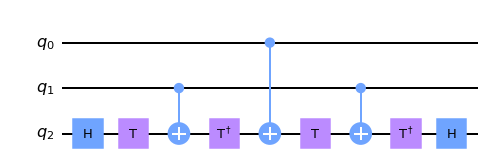

In [13]:
# Build circuit
qc = QuantumCircuit(3)
qc.h(2)
qc.t(2)
qc.cx(1, 2)
qc.tdg(2)
qc.cx(0, 2)
qc.t(2)
qc.cx(1, 2)
qc.tdg(2)
qc.h(2)

# Store to gate
RT3 = qc.to_instruction(label='RT3')
RT3dg = RT3.inverse()
RT3dg.label = 'RT3dg'

# Check that it is indeed the relative phase Toffoli 3 gate
u_RT3 = Operator(qc).data
qc_T3 = QuantumCircuit(3)
qc_T3.ccx(0, 1, 2)
u_T3 = Operator(qc_T3).data
print('is relative:', is_relative(u_RT3, u_T3))

# Draw
qc.draw(output='mpl')

Here is another version of the relative Toffoli 3 gate, which is called special relative Toffoli 3 or $SRT^3$.

is relative: True


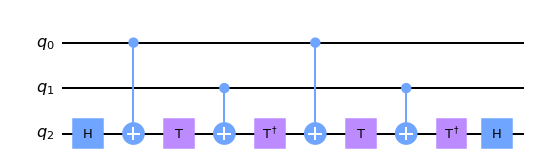

In [14]:
# Similar to the privious circuit but with an additional CZ gate
qc = QuantumCircuit(3)
qc.h(2)
qc.cx(0, 2)
qc.h(2)
qc.append(RT3, [0, 1, 2])
qc = qc.decompose('RT3')
qc = transpile(qc, basis_gates=['cx', 't', 'tdg', 'h'], optimization_level=3)
qc.draw(output='mpl')

# Store to gate
SRT3 = qc.to_instruction(label='SRT3')

# Check that it is indeed the relative phase Toffoli 3 gate
u_SRT3 = Operator(qc).data
print('is relative:', is_relative(u_SRT3, u_T3))

# Draw
qc.draw(output='mpl')

The $SRT^3$ is useful because the additional diagonal gate does not affect that target qubit. The price to pay is an additional 2q gate. One immdediate use of the $SRT^3$ is to construct an $RT^4$ gate out of $RT^3$ gate by replacing one of the CNOTs by $SRT^3$ (see Maslov's paper for details).

is relative: True


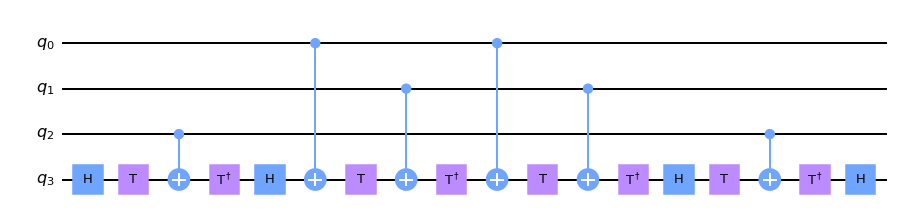

In [15]:
# Build circuit
qc = QuantumCircuit(4)
qc.h(3)
qc.t(3)
qc.cx(2, 3)
qc.tdg(3)
qc.append(SRT3, [0, 1, 3])
qc.t(3)
qc.cx(2, 3)
qc.tdg(3)
qc.h(3)
qc = qc.decompose('SRT3')

# Store to gate
RT4 = qc.to_instruction(label='RT4')
RT4dg = RT4.inverse()
RT4dg.label = 'RT4dg'

# Check that it is indeed the relative phase Toffoli 3 gate
u_RT4 = Operator(qc).data
qc_T4 = QuantumCircuit(4)
qc_T4.mct([0, 1, 2], 3)
u_T4 = Operator(qc_T4).data
print('is relative:', is_relative(u_RT4, u_T4))

# Draw
qc.draw(output='mpl')

Finally, we will need an $RT^5$ gate in our construction. I haven't found a ready-to use implementation in the literature, so I will construct my own in the same way as we have just constructed $RT^4$ from $RT^3$. Namely, in the above diagram we will replace two CNOT gates acting between q0 and q3 by $SRT^3$. 

addition: As I found later, using shorter $RT^3$ instead of $SRT^3$ also works here, not sure why but I'll sure go with the shorter option.

is relative: True


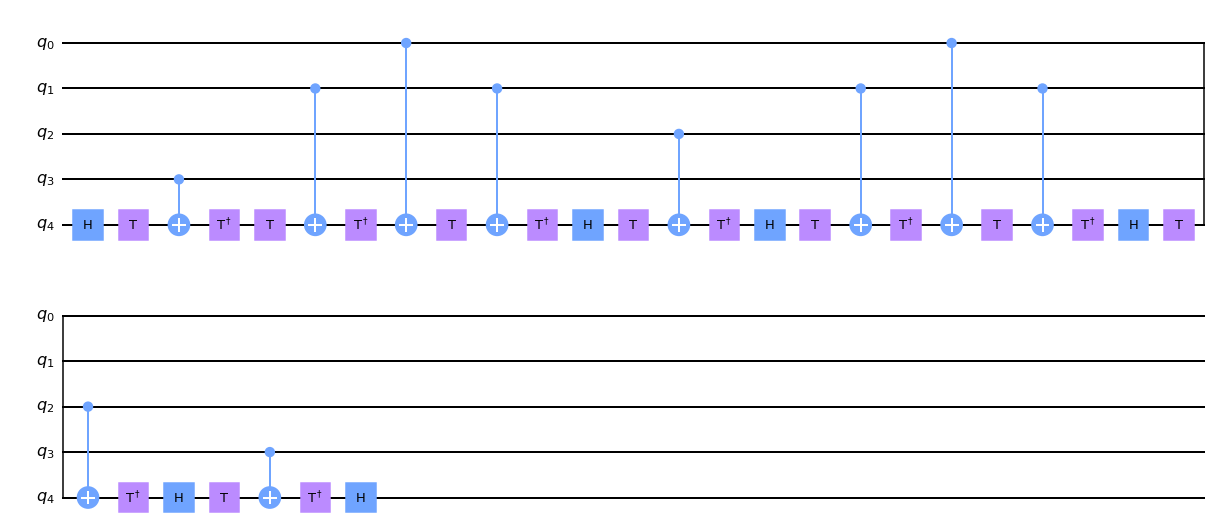

In [16]:
# Build circuit
qc = QuantumCircuit(5)
qc.h(4)
qc.t(4)
qc.cx(3, 4)
qc.tdg(4)
qc.h(4)
qc.append(RT3, [0, 1, 4])
qc.t(4)
qc.cx(2, 4)
qc.tdg(4)
qc.append(RT3, [0, 1, 4])
qc.t(4)
qc.cx(2, 4)
qc.tdg(4)
qc.h(4)
qc.t(4)
qc.cx(3, 4)
qc.tdg(4)
qc.h(4)

qc = qc.decompose('RT3')
qc = transpile(qc, basis_gates=['cx', 't', 'tdg', 'h'], optimization_level=3)

# Store to gate
RT5 = qc.to_instruction(label='RT5')
RT5dg = RT5.inverse()
RT5dg.label = 'RT5dg'


# Check that it is indeed the relative phase Toffoli 3 gate
u_RT5 = Operator(qc).data
qc_T5 = QuantumCircuit(5)
qc_T5.mct([0, 1, 2, 3], 4)
u_T5 = Operator(qc_T5).data
print('is relative:', is_relative(u_RT5, u_T5))

# Draw
qc.draw(output='mpl')

There is no guarantee that this is the best implementation of $RT^5$, but it looks quite efficient to me. Note that $T$ and $T^\dagger$ operators aren't canceled, we will deal with this later when the final circuit is transpiled into 'u' 1q basis.

# 5q Toffoli with a clean ancilla

The last ingredient I will need to fill my skeleton is the construction an efficient implementation of the $AND4$ gate transferring the results from 4 ancilla to the target qubit. At this point we also have the fifth clean ancilla ot our disposal. The circuit I will use is again borrowed from Maslov.

total depth: 36
CX depth: 18


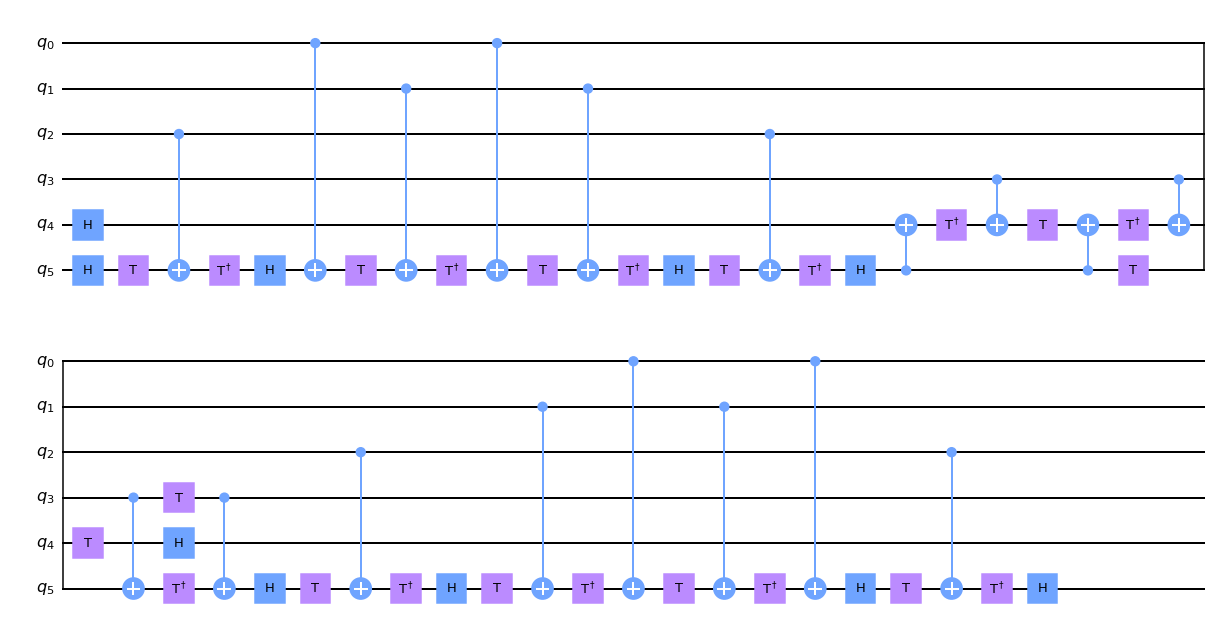

In [17]:
# Build circuit
qc = QuantumCircuit(6)
qc.append(RT4, [0, 1, 2, 5])
qc.ccx(3, 5, 4)
qc.append(RT4dg, [0, 1, 2, 5])

# Uncomment to test equivalence to the Toffoli 5
# qc.ccx(3, 5, 4) 
# qc_test = QuantumCircuit(6)
# qc_test.mct([0, 1, 2, 3], 4)
# print(Operator(qc).equiv(Operator(qc_test)))

# Store to gate
qc = qc.decompose(['RT4', 'RT4dg', 'ccx'])
T5_ancilla = qc.to_instruction(label='T51')

# Draw
get_depth(qc)
qc.draw(output='mpl')

# Assemble into the final circuit.

With all ingredients in place let us assemble the final circuit.

In [18]:
# Replacing all AND gates by their plain Toffoli implentations.
qc = qc_skeleton.copy()
qc.replace('AND4', RT5)
qc.replace('AND3', RT4)

qc.replace('AND41', T5_ancilla)

qc.replace('AND4dg', RT5dg)
qc.replace('AND3dg', RT4dg)

qc.draw()

┌──────┐        ┌────────┐
t4_0: ┤0     ├────────┤0       ├
      │      │        │        │
t4_1: ┤1     ├────────┤1       ├
      │      │        │        │
t4_2: ┤2 RT5 ├────────┤2 RT5dg ├
      │      │        │        │
t4_3: ┤3     ├────────┤3       ├
      │      │┌──────┐│        │
 at4: ┤4     ├┤0     ├┤4       ├
      ├──────┤│      │├────────┤
t3_0: ┤0     ├┤      ├┤0       ├
      │      ││      ││        │
t3_1: ┤1     ├┤      ├┤1       ├
      │  RT4 ││      ││  RT4dg │
t3_2: ┤2     ├┤      ├┤2       ├
      │      ││      ││        │
 at3: ┤3     ├┤1     ├┤3       ├
      └──────┘│      │└────────┘
  aa: ────────┤5     ├──────────
              │  T51 │          
targ: ────────┤4     ├──────────
      ┌──────┐│      │┌────────┐
 bt3: ┤3     ├┤2     ├┤3       ├
      │      ││      ││        │
b3_0: ┤0     ├┤      ├┤0       ├
      │  RT4 ││      ││  RT4dg │
b3_1: ┤1     ├┤      ├┤1       ├
      │      ││      ││        │
b3_2: ┤2     ├┤      ├┤2       ├
      ├──────┤│      │├────────┤
 bt4: ┤4     ├┤3     ├┤4       ├
      │      │└──────┘│        │
b4_0: ┤0     ├────────┤0       ├
      │      │        │        │
b4_1: ┤1 RT5 ├────────┤1 RT5dg ├
      │      │        │        │
b4_2: ┤2     ├────────┤2       ├
      │      │        │        │
b4_3: ┤3     ├────────┤3       ├
      └──────┘        └────────┘

Finally, we reorder qubits and transpile into 'cx'+'u' gate set. That could save a bit of depth when adjacent 1q gates are merged together into a single 'u' gate.

In [19]:
qc_final = transpile(order_registers(qc), basis_gates=['cx', 'u'])
get_depth(qc_final)

total depth: 70
CX depth: 36


Let's check that our simple equivalence test is passed by the circuit.

In [20]:
simple_circuit_check(qc_final)

0 state: True
1 state: True
hadamard state: True


# Plot of the final circuit (very large, expand at your own risk)

Here is the qasm string and the final plot of the circuit.

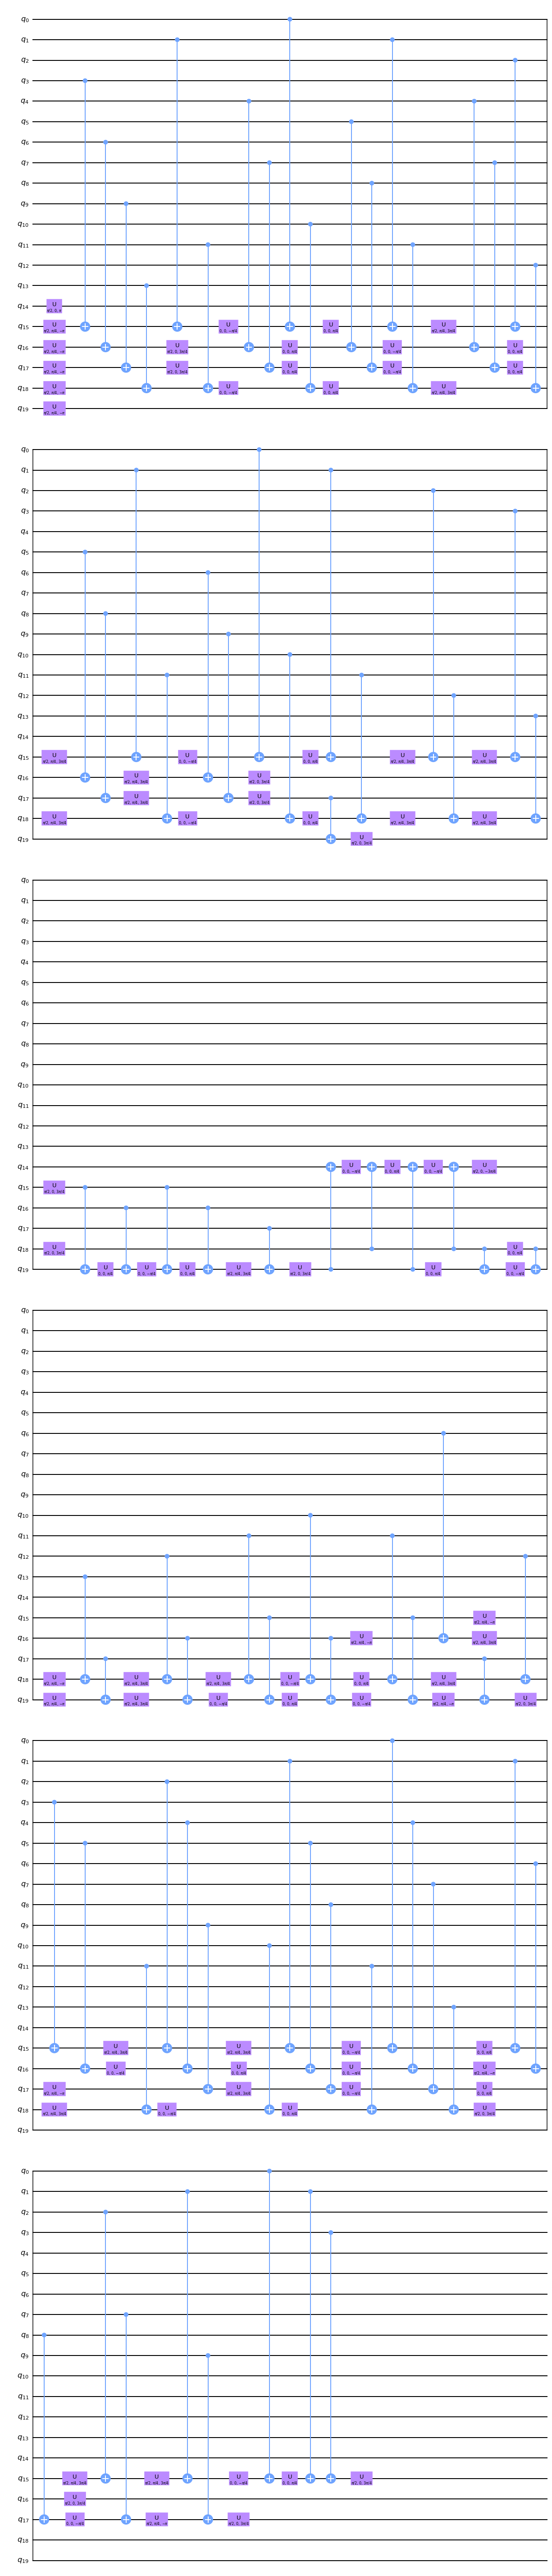

In [21]:
qc_final.draw(output='mpl')

# QASM string of the resulting circuit.

In [22]:
print(qc_final.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[20];
u(pi/2,0,pi) q[14];
u(pi/2,pi/4,-pi) q[15];
cx q[3],q[15];
cx q[1],q[15];
u(0,0,-pi/4) q[15];
cx q[0],q[15];
u(0,0,pi/4) q[15];
cx q[1],q[15];
u(pi/2,pi/4,3*pi/4) q[15];
cx q[2],q[15];
u(pi/2,pi/4,3*pi/4) q[15];
cx q[1],q[15];
u(0,0,-pi/4) q[15];
cx q[0],q[15];
u(0,0,pi/4) q[15];
cx q[1],q[15];
u(pi/2,pi/4,3*pi/4) q[15];
cx q[2],q[15];
u(pi/2,pi/4,3*pi/4) q[15];
cx q[3],q[15];
u(pi/2,0,3*pi/4) q[15];
u(pi/2,pi/4,-pi) q[16];
cx q[6],q[16];
u(pi/2,0,3*pi/4) q[16];
cx q[4],q[16];
u(0,0,pi/4) q[16];
cx q[5],q[16];
u(0,0,-pi/4) q[16];
cx q[4],q[16];
u(0,0,pi/4) q[16];
cx q[5],q[16];
u(pi/2,pi/4,3*pi/4) q[16];
cx q[6],q[16];
u(pi/2,0,3*pi/4) q[16];
u(pi/2,pi/4,-pi) q[17];
cx q[9],q[17];
u(pi/2,0,3*pi/4) q[17];
cx q[7],q[17];
u(0,0,pi/4) q[17];
cx q[8],q[17];
u(0,0,-pi/4) q[17];
cx q[7],q[17];
u(0,0,pi/4) q[17];
cx q[8],q[17];
u(pi/2,pi/4,3*pi/4) q[17];
cx q[9],q[17];
u(pi/2,0,3*pi/4) q[17];
u(pi/2,pi/4,-pi) q[18];
cx q[13],q[18];
cx q[11],q[18]